# Functional E/I Ratio During Medication Taper

In [1]:
import os, pickle
import numpy as np
import pandas as pd
from ieeg_utils import *
from scipy import signal
from scipy.signal import detrend
import matplotlib.pyplot as plt

In [2]:
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
TABLES_DIRECTORY = "../../Data/giant_tables"

In [83]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = str(filename.split("_")[1].split(".")[0])
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = [165, 190, 142, 216]
patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

4

In [84]:
# Create an empty dictionary to store all the data
data_dict = {"dataset_name": [], "max_hour": [], "sample_rate": [], "hup_id": []}

# Iterate through the directory
for filename in os.listdir(IEEG_DIRECTORY):
    if filename.endswith(".pkl"):  # Only process .pkl files
        # Split the filename to get the dataset_name, hour, and sample_rate
        parts = filename.split("_")
        dataset_name = "_".join(parts[:-4])  # Exclude the '_hr' from the dataset_name
        hour = int(parts[-3])
        sample_rate = int(parts[-1].split(".")[0])

        # Extract hup_id from dataset_name
        hup_id = dataset_name.split("_")[0].split("HUP")[1]

        # If the dataset_name is already in the dictionary, update the max_hour
        if dataset_name in data_dict["dataset_name"]:
            index = data_dict["dataset_name"].index(dataset_name)
            data_dict["max_hour"][index] = max(data_dict["max_hour"][index], hour)
        else:
            # Else, add the dataset_name, hour, sample_rate and hup_id to the dictionary
            data_dict["dataset_name"].append(dataset_name)
            data_dict["max_hour"].append(hour)
            data_dict["sample_rate"].append(sample_rate)
            data_dict["hup_id"].append(hup_id)

# Create a DataFrame from the dictionary
datasets_df = pd.DataFrame(data_dict)
# Make max_hour and sample_rate and hup_id integers
datasets_df["max_hour"] = datasets_df["max_hour"].astype(int)
datasets_df["sample_rate"] = datasets_df["sample_rate"].astype(int)
datasets_df["hup_id"] = datasets_df["hup_id"].astype(int)
# Sort by hup_id
datasets_df = datasets_df.sort_values(by=["hup_id"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# Create a column called max_hour_count that is the max_hour + 1
datasets_df["max_hour_count"] = datasets_df["max_hour"] + 1
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP138_phaseII,172,1024,138,173
1,HUP140_phaseII_D02,128,1024,140,129
2,HUP140_phaseII_D01,19,1024,140,20
3,HUP141_phaseII,146,512,141,147
4,HUP142_phaseII,311,512,142,312
...,...,...,...,...,...
81,HUP215_phaseII_D01,14,2048,215,15
82,HUP216_phaseII_D01,143,512,216,144
83,HUP216_phaseII_D02,144,512,216,145
84,HUP223_phaseII,135,1024,223,136


In [86]:
# Only keep the datasets that are in the patient_hup_ids
datasets_df = datasets_df[datasets_df["hup_id"].isin(patient_hup_ids)]
# Sort by hup_id then by dataset_name
datasets_df = datasets_df.sort_values(by=["hup_id", "dataset_name"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# # Drop the row with dataset_name = HUP165_phaseII_D02
datasets_df = datasets_df.drop(
    datasets_df[datasets_df["dataset_name"] == "HUP165_phaseII_D02"].index
)
datasets_df = datasets_df.drop(
    datasets_df[datasets_df["dataset_name"] == "HUP216_phaseII_D02"].index
)
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP142_phaseII,311,512,142,312
1,HUP165_phaseII,459,1024,165,460
2,HUP190_phaseII,306,1024,190,307
3,HUP216_phaseII_D01,143,512,216,144


In [65]:
def create_window_indices(length_signal, length_window, window_offset):
    window_starts = np.arange(0, length_signal - length_window + 1, window_offset)
    num_windows = len(window_starts)

    one_window_index = np.arange(length_window)
    all_window_index = np.repeat(one_window_index[None, :], num_windows, axis=0)

    all_window_index = all_window_index + window_starts[:, None]

    return all_window_index


def calculate_fei(signal, window_size, window_overlap):
    length_signal, num_channels = signal.shape

    window_offset = int(window_size * (1 - window_overlap))
    all_window_index = create_window_indices(length_signal, window_size, window_offset)
    num_windows = all_window_index.shape[0]

    ei = np.zeros(num_channels)
    w_amp = np.zeros((num_channels, num_windows))
    w_dnf = np.zeros((num_channels, num_windows))

    for i_channel in range(num_channels):
        original_amplitude = signal[:, i_channel]

        signal_profile = np.cumsum(original_amplitude - np.mean(original_amplitude))
        w_original_amplitude = np.mean(original_amplitude[all_window_index], axis=1)
        x_amp = np.repeat(w_original_amplitude[:, None], window_size, axis=1)
        x_signal = signal_profile[all_window_index]
        x_signal = (x_signal / x_amp).T
        d_signal = detrend(x_signal, axis=0)
        w_detrended_normalized_fluctuations = np.std(d_signal, axis=0)
        ei[i_channel] = (
            1
            - np.corrcoef(w_detrended_normalized_fluctuations, w_original_amplitude)[
                0, 1
            ]
        )
        w_amp[i_channel, :] = w_original_amplitude
        w_dnf[i_channel, :] = w_detrended_normalized_fluctuations

    return ei, w_amp, w_dnf

In [66]:
# Test the function
np.random.seed(0)  # for reproducibility
test_signal = np.random.randn(100000, 1)
window_size = 3000
window_overlap = 0.5

test_signal.shape

(100000, 1)

In [67]:
ei, w_amp, w_dnf = calculate_fei(test_signal, window_size, window_overlap)
ei

array([1.01004416])

## High AED vs Low AED for HUP 165

Loading HUP142_phaseII_hr_0_fs_512.pkl
Loading HUP142_phaseII_hr_1_fs_512.pkl
Loading HUP142_phaseII_hr_2_fs_512.pkl
Loading HUP142_phaseII_hr_3_fs_512.pkl
Loading HUP142_phaseII_hr_4_fs_512.pkl
Loading HUP142_phaseII_hr_5_fs_512.pkl
Loading HUP142_phaseII_hr_72_fs_512.pkl
Loading HUP142_phaseII_hr_73_fs_512.pkl
Loading HUP142_phaseII_hr_74_fs_512.pkl
Loading HUP142_phaseII_hr_75_fs_512.pkl
Loading HUP142_phaseII_hr_76_fs_512.pkl
Loading HUP142_phaseII_hr_77_fs_512.pkl


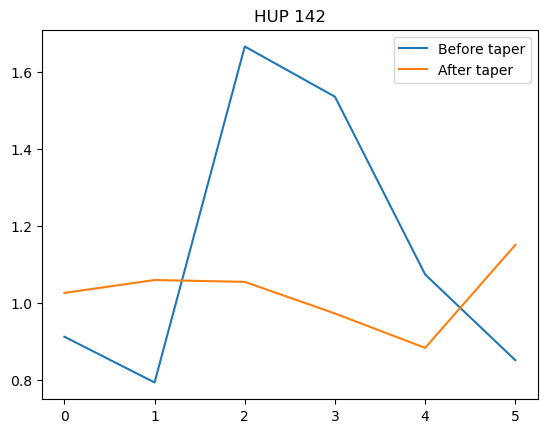

Loading HUP165_phaseII_hr_0_fs_1024.pkl
Loading HUP165_phaseII_hr_1_fs_1024.pkl
Loading HUP165_phaseII_hr_2_fs_1024.pkl
Loading HUP165_phaseII_hr_3_fs_1024.pkl
Loading HUP165_phaseII_hr_4_fs_1024.pkl
Loading HUP165_phaseII_hr_5_fs_1024.pkl
Loading HUP165_phaseII_hr_72_fs_1024.pkl
Loading HUP165_phaseII_hr_73_fs_1024.pkl
Loading HUP165_phaseII_hr_74_fs_1024.pkl
Loading HUP165_phaseII_hr_75_fs_1024.pkl
Loading HUP165_phaseII_hr_76_fs_1024.pkl
Loading HUP165_phaseII_hr_77_fs_1024.pkl


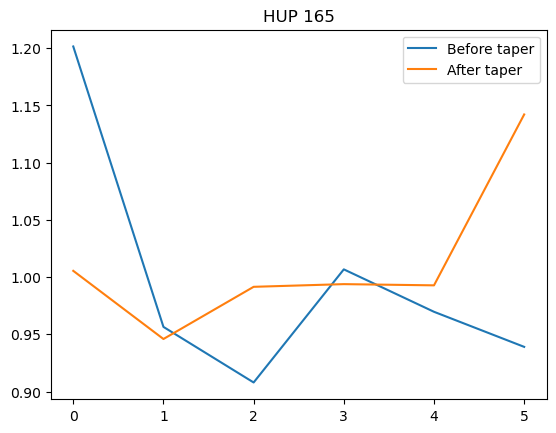

Loading HUP190_phaseII_hr_0_fs_1024.pkl
Loading HUP190_phaseII_hr_1_fs_1024.pkl
Loading HUP190_phaseII_hr_2_fs_1024.pkl
Loading HUP190_phaseII_hr_3_fs_1024.pkl
Loading HUP190_phaseII_hr_4_fs_1024.pkl
Loading HUP190_phaseII_hr_5_fs_1024.pkl
Loading HUP190_phaseII_hr_72_fs_1024.pkl
Loading HUP190_phaseII_hr_73_fs_1024.pkl
Loading HUP190_phaseII_hr_74_fs_1024.pkl
Loading HUP190_phaseII_hr_75_fs_1024.pkl
Loading HUP190_phaseII_hr_76_fs_1024.pkl
Loading HUP190_phaseII_hr_77_fs_1024.pkl


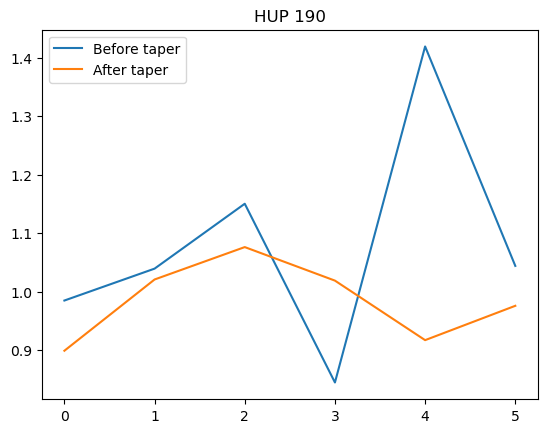

Loading HUP216_phaseII_D01_hr_0_fs_512.pkl
Loading HUP216_phaseII_D01_hr_1_fs_512.pkl
Loading HUP216_phaseII_D01_hr_2_fs_512.pkl
Loading HUP216_phaseII_D01_hr_3_fs_512.pkl
Loading HUP216_phaseII_D01_hr_4_fs_512.pkl
Loading HUP216_phaseII_D01_hr_5_fs_512.pkl
Loading HUP216_phaseII_D01_hr_72_fs_512.pkl
Loading HUP216_phaseII_D01_hr_73_fs_512.pkl
Loading HUP216_phaseII_D01_hr_74_fs_512.pkl
Loading HUP216_phaseII_D01_hr_75_fs_512.pkl
Loading HUP216_phaseII_D01_hr_76_fs_512.pkl
Loading HUP216_phaseII_D01_hr_77_fs_512.pkl


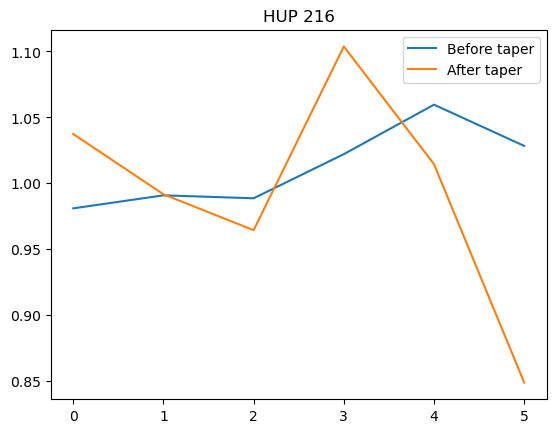

In [88]:
before_taper_hours = [0, 1, 2, 3, 4, 5]
after_taper_hours = [72, 73, 74, 75, 76, 77]


for patient_hup_id in patient_hup_ids:
    before_taper_fEI_list = []
    after_taper_fEI_list = []

    if patient_hup_id == 190:
        soz_channel_pair = ["LA01", "LA02"]
    elif patient_hup_id == 165:
        soz_channel_pair = ["RA03", "RA04"]
    elif patient_hup_id == 142:
        soz_channel_pair = ["LDA01", "LDA02"]
    elif patient_hup_id == 216:
        soz_channel_pair = ["LC01", "LC02"]

    for hour in before_taper_hours:
        # Get the row in datasets_df correspinding the patient_hup_id
        patient_datasets_df = datasets_df[datasets_df["hup_id"] == patient_hup_id]

        # Find the dataset_name and sample_rate for the first row in patient_datasets_df
        dataset_name = patient_datasets_df.iloc[0]["dataset_name"]
        sample_rate = patient_datasets_df.iloc[0]["sample_rate"]

        # Get the filename
        filename = f"{dataset_name}_hr_{hour}_fs_{sample_rate}.pkl"

        print(f"Loading {filename}")
        # Get the full path to the file
        full_path = os.path.join(IEEG_DIRECTORY, filename)

        # Load the data
        try:
            with open(full_path, "rb") as f:
                # print(f"Loading {filename}")
                eeg_segment_df = pickle.load(f)
        except FileNotFoundError:
            print(f"Skipping {hour} for {dataset_name}")
            continue

        # apply notch filters to remove 60 Hz noise
        notch_b, notch_a = signal.iirnotch(60, 30, sample_rate)
        data_notch_filtered_RA3 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df[soz_channel_pair[0]].to_numpy()
        )
        data_notch_filtered_RA4 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df[soz_channel_pair[1]].to_numpy()
        )

        bipolar_signal = data_notch_filtered_RA3 - data_notch_filtered_RA4
        # Reshape the signal to be a 2D array
        bipolar_signal = bipolar_signal.reshape(-1, 1)
        f_EI = calculate_fei(bipolar_signal, window_size, window_overlap)[0][0]
        before_taper_fEI_list.append(f_EI)

    for hour in after_taper_hours:
        # Get the row in datasets_df correspinding the patient_hup_id
        patient_datasets_df = datasets_df[datasets_df["hup_id"] == patient_hup_id]

        # Find the dataset_name and sample_rate for the first row in patient_datasets_df
        dataset_name = patient_datasets_df.iloc[0]["dataset_name"]
        sample_rate = patient_datasets_df.iloc[0]["sample_rate"]

        # Get the filename
        filename = f"{dataset_name}_hr_{hour}_fs_{sample_rate}.pkl"

        print(f"Loading {filename}")
        # Get the full path to the file
        full_path = os.path.join(IEEG_DIRECTORY, filename)

        # Load the data
        try:
            with open(full_path, "rb") as f:
                # print(f"Loading {filename}")
                eeg_segment_df = pickle.load(f)
        except FileNotFoundError:
            print(f"Skipping {hour} for {dataset_name}")
            continue

        # apply notch filters to remove 60 Hz noise
        notch_b, notch_a = signal.iirnotch(60, 30, sample_rate)
        data_notch_filtered_RA3 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df[soz_channel_pair[0]].to_numpy()
        )
        data_notch_filtered_RA4 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df[soz_channel_pair[1]].to_numpy()
        )

        bipolar_signal = data_notch_filtered_RA3 - data_notch_filtered_RA4
        # Reshape the signal to be a 2D array
        bipolar_signal = bipolar_signal.reshape(-1, 1)
        f_EI = calculate_fei(bipolar_signal, window_size, window_overlap)[0][0]
        after_taper_fEI_list.append(f_EI)

    plt.plot(before_taper_fEI_list, label="Before taper")
    plt.plot(after_taper_fEI_list, label="After taper")
    plt.title(f"HUP {patient_hup_id}")
    plt.legend()
    plt.show()

## Old Continuous for HUP 165

In [13]:
f_EI_list = []
for patient_hup_id in patient_hup_ids:
    for eeg_hour in range(0, 300):
        print(f"Processing hour {eeg_hour}")

        # Get the row in datasets_df correspinding the patient_hup_id
        patient_datasets_df = datasets_df[datasets_df["hup_id"] == patient_hup_id]

        # Find the dataset_name and sample_rate for the first row in patient_datasets_df
        dataset_name = patient_datasets_df.iloc[0]["dataset_name"]
        sample_rate = patient_datasets_df.iloc[0]["sample_rate"]

        # Get the filename
        filename = f"{dataset_name}_hr_{eeg_hour}_fs_{sample_rate}.pkl"

        print(f"Loading {filename}")
        # Get the full path to the file
        full_path = os.path.join(IEEG_DIRECTORY, filename)

        # Load the data
        try:
            with open(full_path, "rb") as f:
                # print(f"Loading {filename}")
                eeg_segment_df = pickle.load(f)
        except FileNotFoundError:
            print(f"Skipping {eeg_hour} for {dataset_name}")
            continue

        # apply notch filters to remove 60 Hz noise
        notch_b, notch_a = signal.iirnotch(60, 30, sample_rate)
        data_notch_filtered_RA3 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df["RA03"].to_numpy()
        )
        data_notch_filtered_RA4 = signal.filtfilt(
            notch_b, notch_a, eeg_segment_df["RA04"].to_numpy()
        )

        bipolar_signal = data_notch_filtered_RA3 - data_notch_filtered_RA4
        # Reshape the signal to be a 2D array
        bipolar_signal = bipolar_signal.reshape(-1, 1)
        f_EI = calculate_fei(bipolar_signal, window_size, window_overlap)[0][0]
        print(f_EI)
        f_EI_list.append(f_EI)
        # plt.plot(bipolar_signal)

Processing hour 0
Loading HUP165_phaseII_hr_0_fs_1024.pkl
1.2014596082959723
Processing hour 1
Loading HUP165_phaseII_hr_1_fs_1024.pkl
0.9564498957374493
Processing hour 2
Loading HUP165_phaseII_hr_2_fs_1024.pkl
0.907892177018077
Processing hour 3
Loading HUP165_phaseII_hr_3_fs_1024.pkl
1.006720376146304
Processing hour 4
Loading HUP165_phaseII_hr_4_fs_1024.pkl
0.9696514927966823
Processing hour 5
Loading HUP165_phaseII_hr_5_fs_1024.pkl
0.9390085910775084
Processing hour 6
Loading HUP165_phaseII_hr_6_fs_1024.pkl
0.7215290929841398
Processing hour 7
Loading HUP165_phaseII_hr_7_fs_1024.pkl
0.9980750771580419
Processing hour 8
Loading HUP165_phaseII_hr_8_fs_1024.pkl
0.8587396084477008
Processing hour 9
Loading HUP165_phaseII_hr_9_fs_1024.pkl
0.985012003879956
Processing hour 10
Loading HUP165_phaseII_hr_10_fs_1024.pkl
0.9805290302655699
Processing hour 11
Loading HUP165_phaseII_hr_11_fs_1024.pkl
1.0034652962145032
Processing hour 12
Loading HUP165_phaseII_hr_12_fs_1024.pkl
0.9820147977637

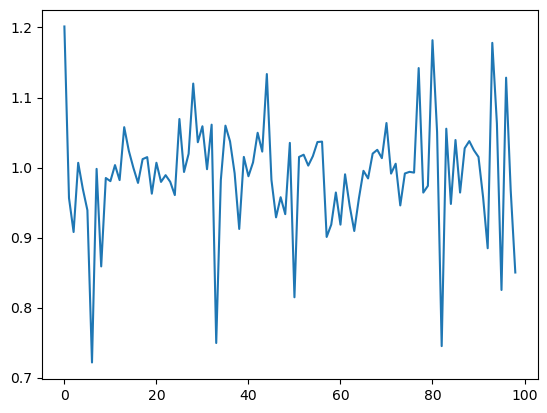

In [10]:
plt.plot(f_EI_list)